In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext autoreload
%autoreload 2
from src.cdhit import CDHIT

In [3]:
aas = 'ACDEFGHIKLMNOPQRSTVWY'
aa_mw = 110 # average AA in mol/L

dbaasp = pd.read_csv('./data/peptides-complete.csv')

dbaasp = dbaasp.query('`COMPLEXITY`=="Monomer"')
# did this b/c Capecchi et al did it
dbaasp = dbaasp.query('(`N TERMINUS`!=`N TERMINUS`)&(`C TERMINUS`!=`C TERMINUS`)|(`N TERMINUS`=="ACT")&(`C TERMINUS`=="AMD")')
dbaasp = dbaasp.dropna(subset=['SEQUENCE','TARGET ACTIVITY - TARGET SPECIES','TARGET ACTIVITY - CONCENTRATION'])
# only natural AAs
dbaasp = dbaasp.loc[dbaasp['SEQUENCE'].map(lambda s: all([c in aas for c in s]))]
# not sure about correspondence of these units! ... need to compute mass of the peptides
dbaasp = dbaasp.query('`TARGET ACTIVITY - UNIT`=="µM"|`TARGET ACTIVITY - UNIT`=="µg/ml"')
# dbaasp = dbaasp.query('`TARGET ACTIVITY - UNIT`=="µM"')
dbaasp

/home/gridsan/mmurphy/.conda/envs/NileRed/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (9,10,11,15,16,17,18,23,24,28,31,32,38,42,46,53,54,56,57,64,65,66,67,68,71,76,79) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ID,COMPLEXITY,NAME,N TERMINUS,SEQUENCE,C TERMINUS,SYNTHESIS TYPE,TARGET GROUP,TARGET OBJECT,PDB NAME,...,UNIRPROT - PRO PEPTIDE,UNIRPROT - URL,ARTICLES - JOURNAL,ARTICLES - YEAR,ARTICLES - VOLUME,ARTICLES - PAGES,ARTICLES - TITLE,ARTICLES - ADDITIONAL,ARTICLES - PUBMED,ARTICLES - AUTHORS
113,11,Monomer,"Cathelicidin-1, CATH-1, Fowlicidin-1",NaN,RVKRVWPLVIRTVIAGYNLYRAIKKK,NaN,Ribosomal,"Gram+,Gram-,Cancer,Mammalian Cell",Lipid Bilayer,2AMN,...,Precursor,http://www.uniprot.org/uniprot/Q6QLQ5,FASEB J,2006.0,273,2581-2593,Structure-activity relationships of fowlicidin...,NaN,http://www.ncbi.nlm.nih.gov/pubmed/16817888,"Zhang G,Zhang G,Prakash O,Gong YX,Soulages JL,..."
114,11,Monomer,"Cathelicidin-1, CATH-1, Fowlicidin-1",NaN,RVKRVWPLVIRTVIAGYNLYRAIKKK,NaN,Ribosomal,"Gram+,Gram-,Cancer,Mammalian Cell",Lipid Bilayer,2AMN,...,Probable Precursor,http://www.uniprot.org/uniprot/C4PFJ7,J Biol Chem,2006.0,281,2858-2867,Identification and functional characterization...,NaN,http://www.ncbi.nlm.nih.gov/pubmed/16326712,"Xiao Y,Xiao Y,Cai Y,Cai Y,Bommineni YR,Bommine..."
115,11,Monomer,"Cathelicidin-1, CATH-1, Fowlicidin-1",NaN,RVKRVWPLVIRTVIAGYNLYRAIKKK,NaN,Ribosomal,"Gram+,Gram-,Cancer,Mammalian Cell",Lipid Bilayer,2AMN,...,NaN,NaN,Dev Comp Immunol,2016.0,65,8-24,Chicken cathelicidins as potent intrinsically ...,NaN,http://www.ncbi.nlm.nih.gov/pubmed/27328070,"Yacoub HA,Elazzazy AM,Mahmoud MM,Baeshen MN,Al..."
116,11,Monomer,"Cathelicidin-1, CATH-1, Fowlicidin-1",NaN,RVKRVWPLVIRTVIAGYNLYRAIKKK,NaN,Ribosomal,"Gram+,Gram-,Cancer,Mammalian Cell",Lipid Bilayer,2AMN,...,NaN,NaN,Bull Korean Chem Soc,2019.0,40,429–434,Improving Cell Selectivity of Fowlicidin-1 by ...,NaN,http://www.ncbi.nlm.nih.gov/pubmed/,"Rajasekaran G,Kumar SD,Yang S,Shin SY"
117,11,Monomer,"Cathelicidin-1, CATH-1, Fowlicidin-1",NaN,RVKRVWPLVIRTVIAGYNLYRAIKKK,NaN,Ribosomal,"Gram+,Gram-,Cancer,Mammalian Cell",Lipid Bilayer,2AMN,...,NaN,NaN,Eur J Med Chem,2019.0,182,111623,The design of a cell-selective fowlicidin-1-de...,NaN,http://www.ncbi.nlm.nih.gov/pubmed/31473417,"Rajasekaran G,Kumar SD,Yang S,Shin SY"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149316,18966,Monomer,Cyclo(Trp-Glu),NaN,WE,NaN,Synthetic,"Gram-,Cancer,Mammalian Cell",Lipid Bilayer,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149317,18966,Monomer,Cyclo(Trp-Glu),NaN,WE,NaN,Synthetic,"Gram-,Cancer,Mammalian Cell",Lipid Bilayer,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149318,18967,Monomer,Cyclo(Trp-Lys),NaN,WK,NaN,Synthetic,"Gram-,Cancer,Mammalian Cell",Lipid Bilayer,NaN,...,NaN,NaN,Mar Drugs,2022.0,20,85,Anti-Quorum-Sensing Activity of Tryptophan-Con...,NaN,http://www.ncbi.nlm.nih.gov/pubmed/35200615,"Wang Y,Zheng Q,Li L,Pan L,Zhu H"
149319,18967,Monomer,Cyclo(Trp-Lys),NaN,WK,NaN,Synthetic,"Gram-,Cancer,Mammalian Cell",Lipid Bilayer,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = pd.DataFrame()
df['target'] = dbaasp['TARGET ACTIVITY - TARGET SPECIES']
df['target'] = df['target'].map(lambda s: ' '.join(s.split(' ')[:2]))
df['sequence'] = dbaasp['SEQUENCE']
df['activity'] = dbaasp['TARGET ACTIVITY - CONCENTRATION']

# there's also ones that are indicated over a range
df['activity'] = df['activity'].map(lambda s: str(s).split('±')[0].strip())

df = df.loc[df['activity'].str.fullmatch(r'\d+(\.\d+)?')]
df['activity'] = df['activity'].astype(float)

is_density = dbaasp['TARGET ACTIVITY - UNIT']=="µg/ml"
# unsure about this calculation. below makes sense, but leads to bimodal log-distribution. omitting 1e-3 makes unimodal
# uM = umol/L = (ug/mL)(mol/g) x 1e-3
df.loc[is_density,'activity'] = df['activity'][is_density] * df['sequence'][is_density].map(len) / aa_mw

df['activity'] = -np.log(df['activity'])

# # df = df.drop_duplicates() # where do these come from?
df = df.groupby(['target','sequence'],as_index=False).mean()

df = df.loc[df['sequence'].map(len) >= 5] # CDHIT needs...
df = df.loc[df['sequence'].map(len) <= 50]

df

,target,sequence,activity
0,Acetobacterium wieringae,RKGWFKAMKSIAKFIAKEKLKEHL,-1.131402
1,Acholeplasma laidlawii,ALWKTIIKGAGKMIGSLAKNLLGSQAQPES,-1.832581
2,Acholeplasma laidlawii,KLLKLLKLLKLLKLWK,0.248461
3,Acholeplasma laidlawii,KLLKLLLKLLLKLLK,-0.444686
4,Acholeplasma laidlawii,KLLKLLLKLLLKLWK,-0.444686
...,...,...,...
25837,Zymomonas mobilis,FKRIVQIIKKFLR,0.526093
25838,Zymomonas mobilis,FKRIVQLIKDFLR,-2.469639
25839,Zymomonas mobilis,FKRIVQLLKKLLR,0.526093
25840,Zymomonas mobilis,FKRIVQRIKDLLR,-1.553348


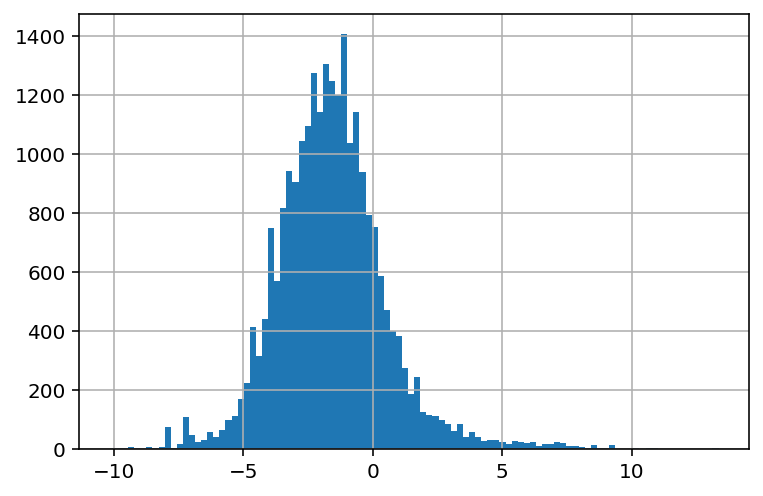

In [5]:
# The left tail indicates active species
(df['activity']).hist(bins=100);

In [6]:
# May just use the top 3-5
df['target'].value_counts().head(20)

Escherichia coli              3542
Staphylococcus aureus         2836
Pseudomonas aeruginosa        1957
Candida albicans              1305
Bacillus subtilis              979
Klebsiella pneumoniae          620
Staphylococcus epidermidis     589
Salmonella typhimurium         525
Enterococcus faecalis          524
Micrococcus luteus             516
Acinetobacter baumannii        371
Salmonella enterica            369
Listeria monocytogenes         287
Enterococcus faecium           232
Cryptococcus neoformans        223
Bacillus cereus                204
Human breast                   196
HIV-1                          195
Human cervical                 189
Enterobacter cloacae           168
Name: target, dtype: int64

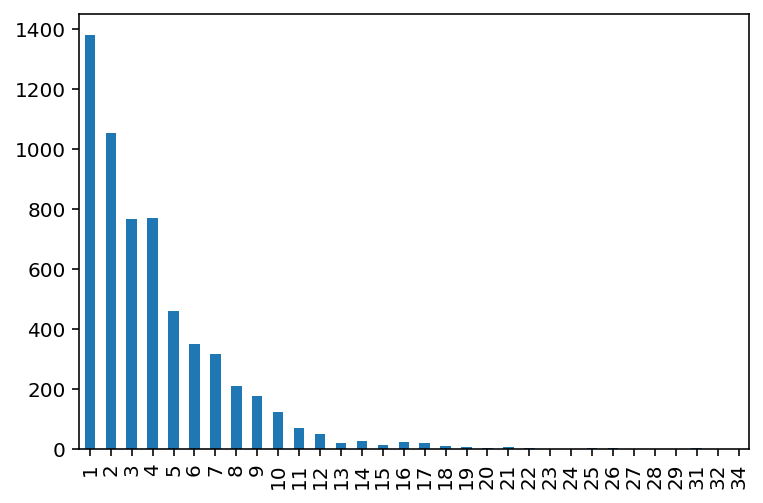

In [7]:
# How many species-activities per sequence?
df['sequence'].value_counts().value_counts().sort_index().plot(kind='bar');

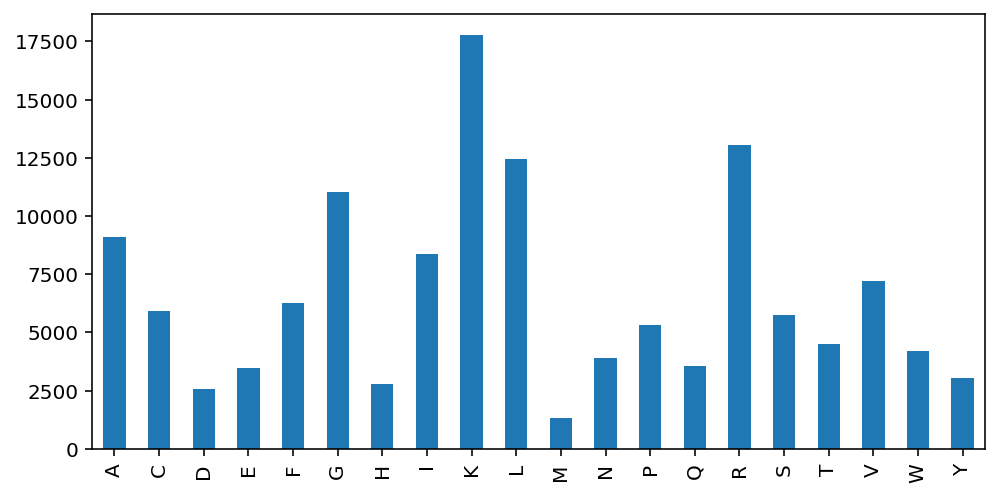

In [8]:
# Amino acid frequencies.
from collections import Counter
pd.Series(Counter(''.join(df['sequence'].unique()))).sort_index().plot(kind='bar',figsize=(8,4));

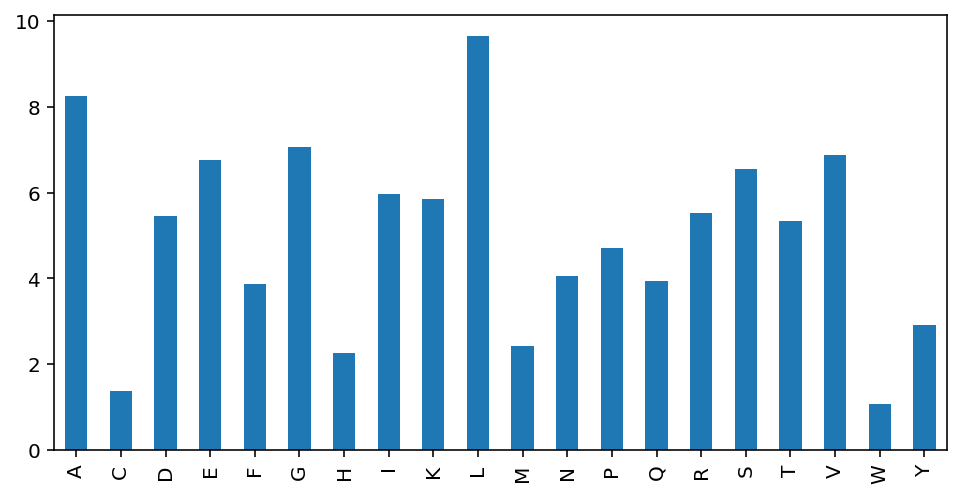

In [9]:
# SwissProt for comparison.
# https://web.expasy.org/protscale/pscale/A.A.Swiss-Prot.html
swissprot = {
    'A':8.25,'R':5.53,'N':4.06,'D':5.45,'C':1.37,
    'Q':3.93,'E':6.75,'G':7.07,'H':2.27,'I':5.96,
    'L':9.66,'K':5.84,'M':2.42,'F':3.86,'P':4.70,
    'S':6.56,'T':5.34,'W':1.08,'Y':2.92,'V':6.87,
}
pd.Series(swissprot).sort_index().plot(kind='bar',figsize=(8,4));

count    24283.000000
mean        23.220195
std         10.393267
min          5.000000
25%         15.000000
50%         21.000000
75%         30.000000
max         50.000000
Name: sequence, dtype: float64

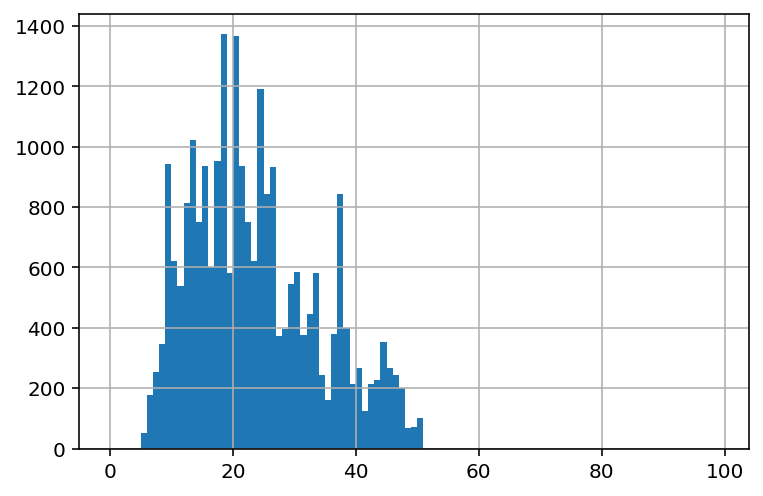

In [10]:
# These sequences are longer than what we see in ProteomeTools Pt1 (tryptic). Substantial overlap still.
df['sequence'].map(len).hist(bins=range(100));
df['sequence'].map(len).describe()

In [11]:
# These are less redundant than the mass spectra: ~13/cluster at 50% similarity there
clusters_50 = CDHIT(threshold=0.5, word_length=3).fit_predict(df['sequence'])
df['sequence'].nunique() / len(set(clusters_50))

6.170680628272251

In [12]:
# 29% of sequences here are tryptic. Overrepresented relative to e.g. SwissProt
tryptic_sequences = [s for s in set(df['sequence']) if s[-1] in 'RK']
len(tryptic_sequences) / df['sequence'].nunique()

0.2901747836416087

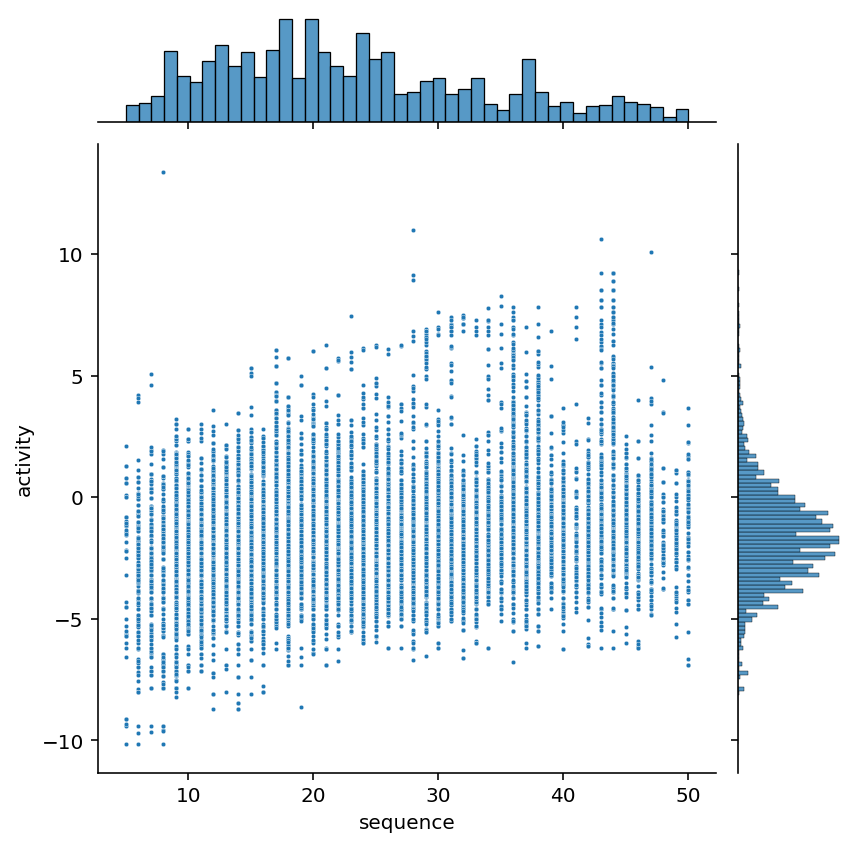

In [19]:
# Relation between length and activity?
sns.jointplot(x=df['sequence'].map(len), y=df['activity'], 
              kind='scatter', joint_kws={'s':5})

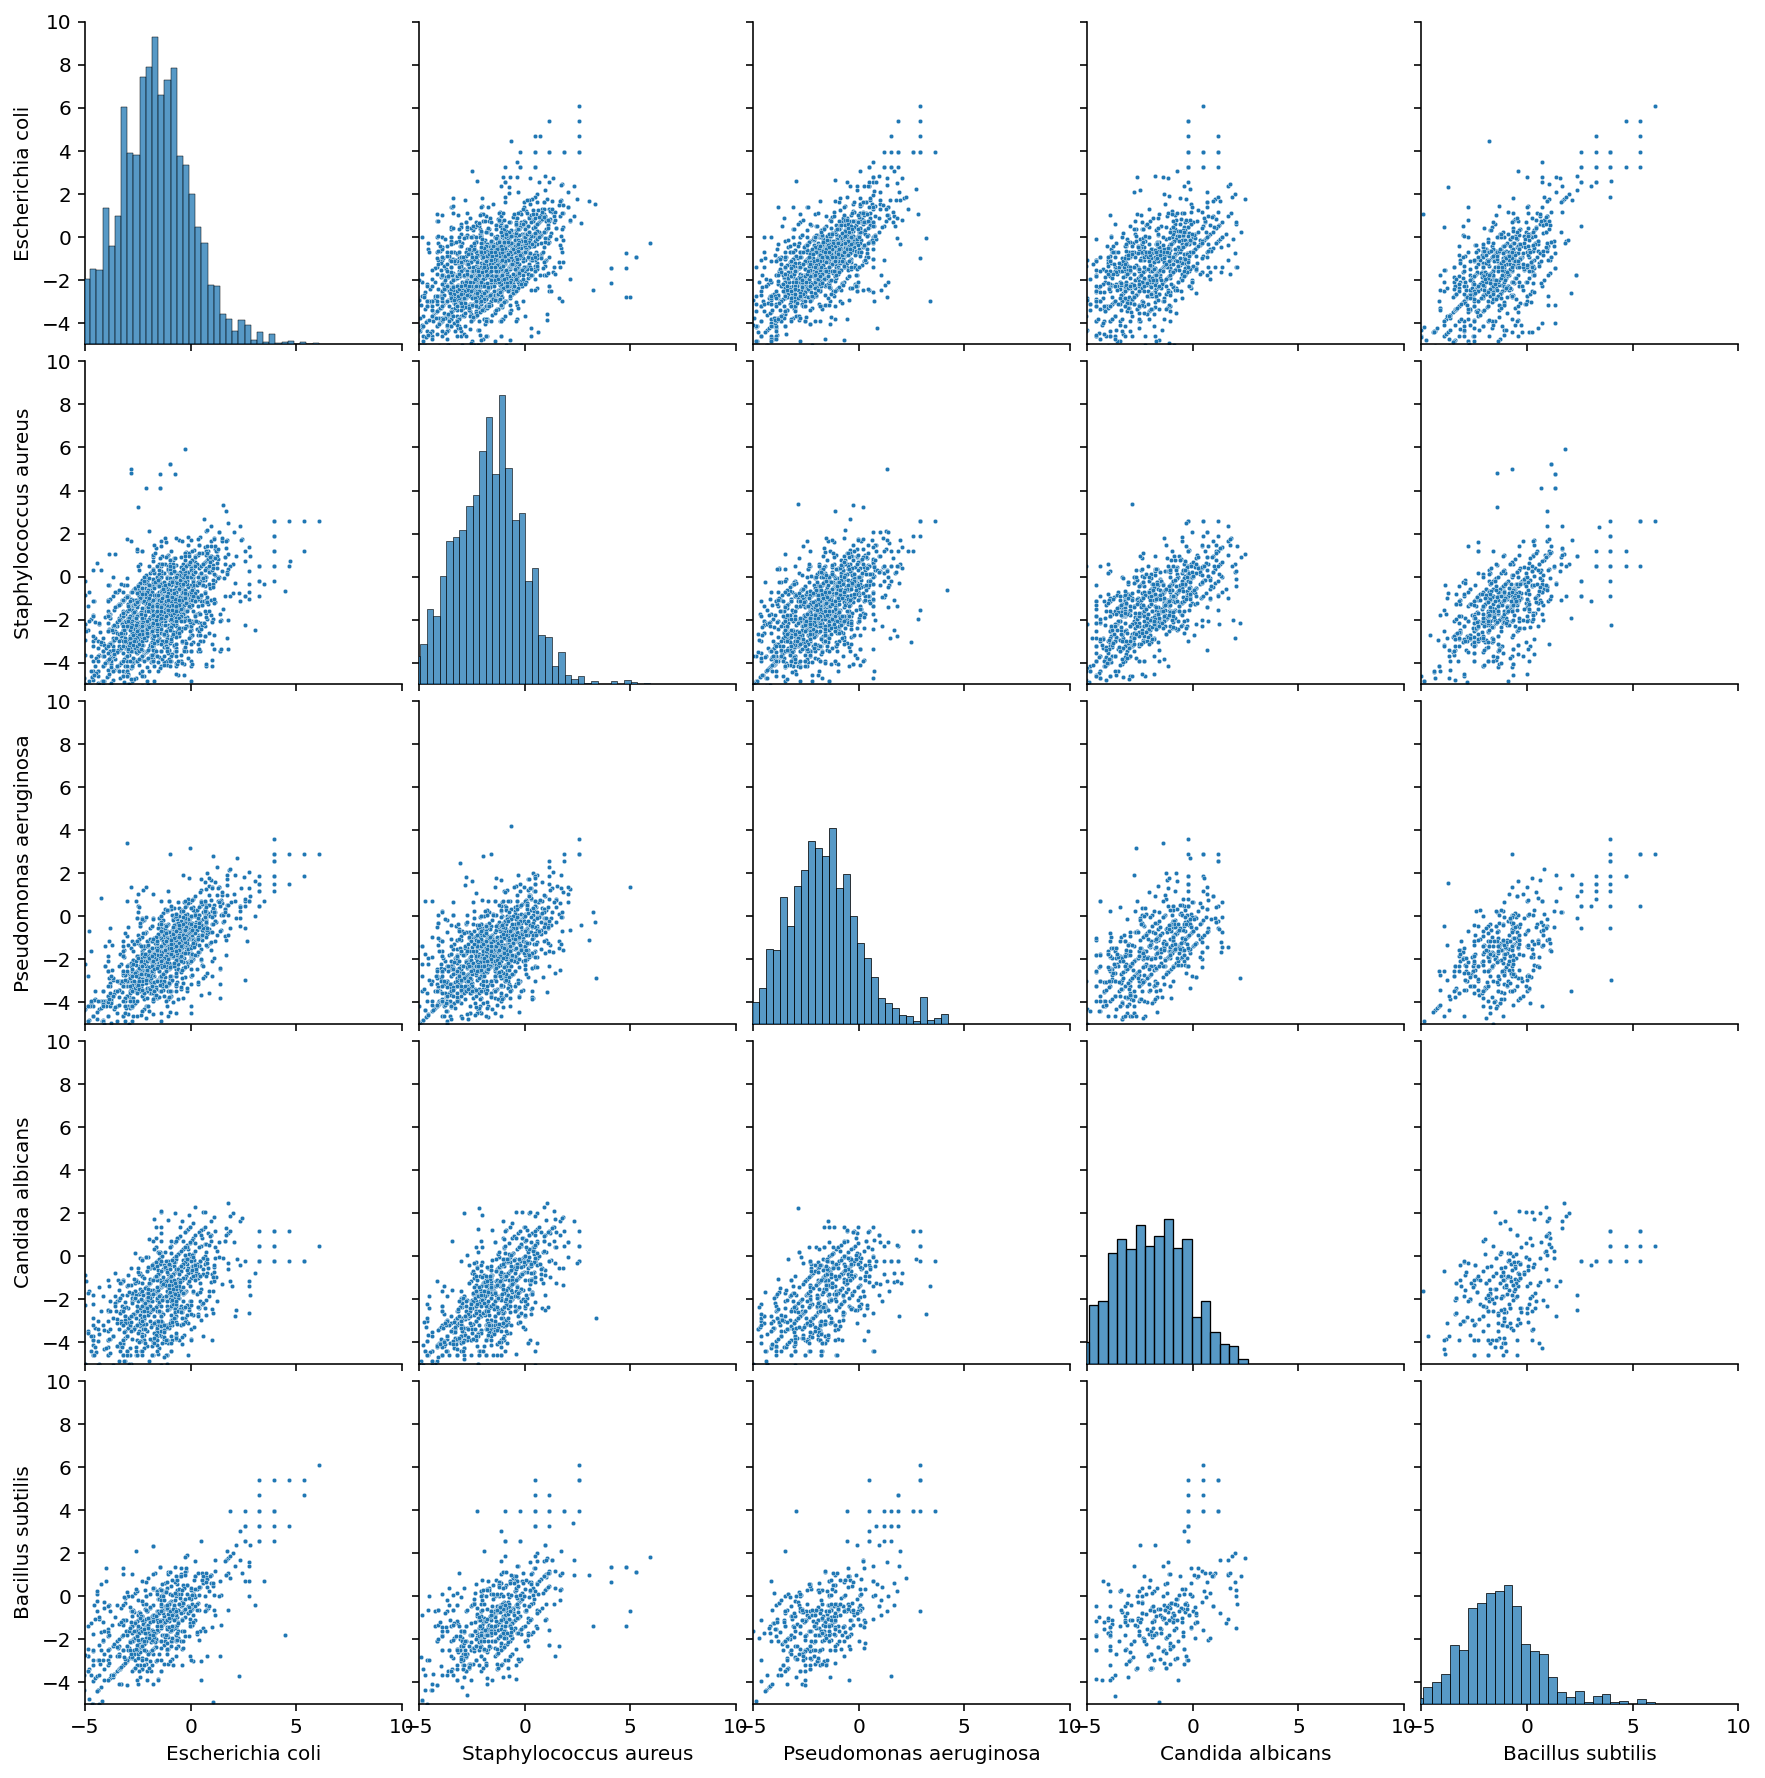

In [14]:
# is this surprising? is it artifact of my density->molarity conversion???
sns.pairplot(
    data=df.pivot_table(index='sequence',columns='target',values='activity')[df['target'].value_counts().index[:5]],
    plot_kws={'s':5}
).set(xlim=(-5,10), ylim=(-5,10))

In [26]:
data = df.pivot_table(index='sequence',columns='target',values='activity')
data = data[df['target'].value_counts().index[:5]].dropna(how='all')
data.to_csv('./data/dbaasp.csv')
data.shape

(4432, 5)